# Churn Prediction of Telco Subscribers
What is churn?
- Churn happens when a customer stops buying/engaging with a product
- Business context could be contractual or non-contractual
- Sometimes churn can be viewed as either voluntary or involuntary.

In this project we will model contractual churn in the telecom business

In [1]:
# import packages
import pandas as pd
import numpy as np 
import scipy 
import statsmodels
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# read in the data
telco_raw = pd.read_csv(r'./data/telco.csv')
telco_raw.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Exploratory Data Analysis
Let's check the data structure and see if it requires cleaning or any transformations.

In [3]:
telco_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
telco_raw.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

The data has just over 7K rows and 21 columns. Most features are strings, except for tenure and monthly charges. Total charges needs further checks as it appears to have a string in it.

Let's separate categorical and numerical columns and do one-hot encoding.

In [5]:
custid = ['customerID']
target = ['Churn']

telco_raw['TotalCharges'] = telco_raw['TotalCharges'].apply(pd.to_numeric, errors='coerce').fillna(method='ffill')

categorical = telco_raw.nunique()[telco_raw.nunique()<10].keys().tolist()
categorical.remove(target[0])
numerical = [col for col in telco_raw.columns if col not in custid+target+categorical]
telco_raw = pd.get_dummies(data=telco_raw, columns=categorical, drop_first=True)
telco_raw.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1,29.85,29.85,No,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,5575-GNVDE,34,56.95,1889.50,No,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,2,53.85,108.15,Yes,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,7795-CFOCW,45,42.30,1840.75,No,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,9237-HQITU,2,70.70,151.65,Yes,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


In [6]:
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(telco_raw[numerical])
scaled_numerical = pd.DataFrame(scaled_numerical, columns=numerical)

In [7]:
telco_raw = telco_raw.drop(columns=numerical, axis=1)
telco = telco_raw.merge(right=scaled_numerical, how='left', left_index=True, right_index=True)

# Supervised Machine Learning
What we'll do:
- Split data to training and testing sets
- Initialize the training model 
- Predict values on testing data 
- Measure performance on testing data 

In [39]:
X = telco.drop(['customerID', 'Churn'], axis=1)
Y = telco['Churn']
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.25, random_state=43)

0.7234525837592277

In [58]:
# Decision Tree Classifier
depth_list = list(range(2,15))
depth_tuning = np.zeros((len(depth_list), 4))
depth_tuning[:,0] = depth_list

for i in range(len(depth_list)):
    dtc = tree.DecisionTreeClassifier(max_depth=depth_list[i])
    dtc.fit(train_x, train_y)
    pred_test_y = dtc.predict(test_x)
    depth_tuning[i, 1] = accuracy_score(test_y, pred_test_y)
    depth_tuning[i, 2] = precision_score(test_y, pred_test_y, pos_label='Yes')
    depth_tuning[i, 3] = recall_score(test_y, pred_test_y, pos_label='Yes')

cols = ['Max_Depth', 'Accuracy', 'Precision', 'Recall']
pd.DataFrame(depth_tuning, columns=cols).style.highlight_max(axis=0, color='red')

,Max_Depth,Accuracy,Precision,Recall
0,2.000000,0.783646,0.599045,0.540948
1,3.000000,0.785917,0.696833,0.331897
2,4.000000,0.796706,0.621560,0.584052
3,5.000000,0.796706,0.633838,0.540948
4,6.000000,0.794435,0.623188,0.556034
5,7.000000,0.785349,0.609694,0.515086
6,8.000000,0.771721,0.574163,0.517241
7,9.000000,0.774560,0.580336,0.521552
8,10.000000,0.767178,0.561086,0.534483
9,11.000000,0.766610,0.559284,0.538793


In [64]:
dtc = tree.DecisionTreeClassifier(max_depth=5)
dtc.fit(train_x, train_y)

import graphviz

exported = tree.export_graphviz(decision_tree=dtc, out_file=None, feature_names=train_x.columns, precision=1, class_names=['Not chunr', 'Churn'], filled=True)
graph = graphviz.Source(exported)
# display(graph)

# Logistic Regression
## Logistic Regression Coefficients
These can be interpreted as change in log-odds of churn associated with 1 unit increase in the feature. They're a tad difficult to interpret, so the solution is to calculate an exponent of the coefficients, giving us the change in odds associated with 1 unit increase in the feature.

In [68]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(train_x, train_y)
coefficients = pd.concat([pd.DataFrame(train_x.columns), pd.DataFrame(np.transpose(logreg.coef_))], axis=1)
coefficients.columns = ['Feature', 'Coefficient']
coefficients['Exp_Coefficient'] = np.exp(coefficients['Coefficient'])
coefficients = coefficients[coefficients['Coefficient']!=0]
coefficients.sort_values(by='Coefficient')


,Feature,Coefficient,Exp_Coefficient
27,tenure,-1.382101,0.251051
22,Contract_Two year,-1.321149,0.266829
21,Contract_One year,-0.704702,0.494256
10,OnlineSecurity_Yes,-0.422630,0.655321
4,PhoneService_Yes,-0.316083,0.728999
16,TechSupport_Yes,-0.301806,0.739481
3,Dependents_Yes,-0.245583,0.782248
12,OnlineBackup_Yes,-0.172928,0.841198
26,PaymentMethod_Mailed check,-0.132468,0.875931
15,TechSupport_No internet service,-0.116112,0.890376


In [34]:
from sklearn.cluster import KMeans 
kmeans = KMeans(n_clusters=3)
kmeans.fit(telco.drop(['customerID', 'Churn'], axis=1))
telco['Cluster'] = kmeans.labels_
telco.groupby('Cluster').mean()

,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.504441,0.192343,0.339663,0.209801,0.83951,0.16049,0.323737,0.510567,0.0,0.0,...,0.339051,0.124962,0.029709,0.664319,0.149158,0.483002,0.215314,-0.684050,0.107564,-0.549757
1,0.510485,0.034076,0.483617,0.421363,1.00000,0.00000,0.224115,0.000000,1.0,1.0,...,0.000000,0.238532,0.418087,0.292267,0.216907,0.079948,0.485583,-0.074273,-1.451829,-0.710620
2,0.501332,0.205151,0.690497,0.347247,0.92984,0.07016,0.698046,0.634547,0.0,0.0,...,0.721581,0.311279,0.426288,0.690941,0.312611,0.295737,0.074600,1.042079,0.827840,1.278580


<AxesSubplot:xlabel='Cluster'>

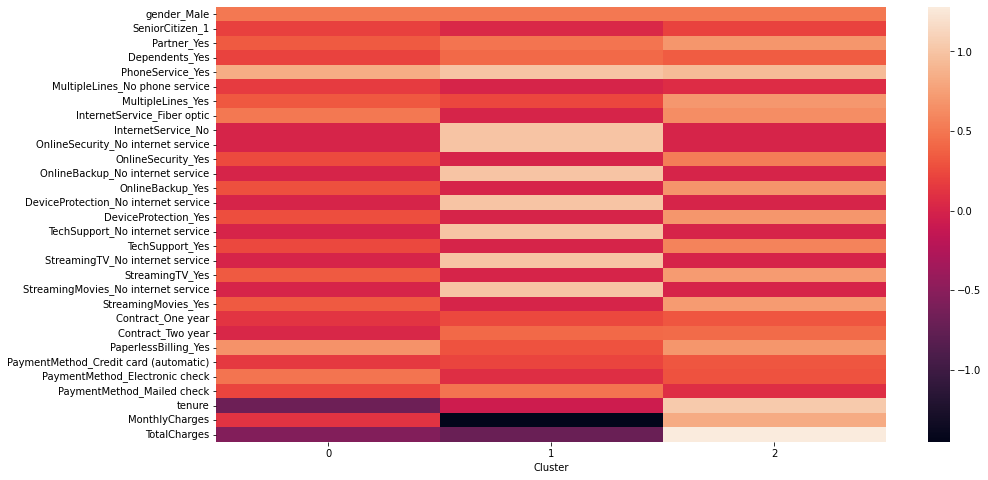

In [38]:
plt.figure(figsize=(15,8))
sns.heatmap(telco.groupby('Cluster').mean().T)


## Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(train_x, train_y)
pred_train_y = logreg.predict(train_x)
pred_test_y = logreg.predict(test_x)
train_accuracy = accuracy_score(train_y, pred_train_y)
test_accuracy = accuracy_score(test_y, pred_test_y)
print('Training accuracy:', round(train_accuracy, 4))
print('Test accuracy:', round(test_accuracy, 4))

Training accuracy: 0.8065
Test accuracy: 0.8041


In [49]:
from sklearn.metrics import precision_score, recall_score

train_precision = round(precision_score(train_y, pred_train_y, pos_label='Yes'), 4)
test_precision = round(precision_score(test_y, pred_test_y, pos_label='Yes'), 4)
test_recall = round(recall_score(test_y, pred_test_y, pos_label='Yes'), 4)
train_recall = round(recall_score(train_y, pred_train_y, pos_label='Yes'))

print('Training precision: {}, Training recall: {}'.format(train_precision, train_recall))
print('Testing precision: {}, Testing recall: {}'.format(test_precision, test_recall))

Training precision: 0.6638, Training recall: 1
Testing precision: 0.6499, Testing recall: 0.556


# Regularization
Lets introduce a penalty coefficient to address overfitting in order to mak the model more generalizable to unseeen samples.

In [54]:
C = [1, .5, .25, .1, .05, .025, .01, .005, .0025]
l1_metrics = np.zeros((len(C), 5))
l1_metrics[:,0] = C

for i in range(0, len(C)):
    logreg = LogisticRegression(penalty='l1', C=C[i], solver='liblinear')
    logreg.fit(train_x, train_y)
    pred_test_y = logreg.predict(test_x)
    l1_metrics[i, 1] = np.count_nonzero(logreg.coef_)
    l1_metrics[i, 2] = accuracy_score(test_y, pred_test_y)
    l1_metrics[i, 3] = precision_score(test_y, pred_test_y, pos_label='Yes')
    l1_metrics[i, 4] = recall_score(test_y, pred_test_y, pos_label='Yes')

cols = ['C', 'Non-Zero Coeffs', 'Accuracy', 'Precision', 'Recall']
pd.DataFrame(l1_metrics, columns=cols).style.highlight_max(color='red', axis=0)

,C,Non-Zero Coeffs,Accuracy,Precision,Recall
0,1.000000,24.000000,0.800114,0.640704,0.549569
1,0.500000,21.000000,0.798978,0.639594,0.543103
2,0.250000,21.000000,0.802385,0.648718,0.545259
3,0.100000,17.000000,0.803521,0.652850,0.543103
4,0.050000,16.000000,0.800114,0.650538,0.521552
5,0.025000,14.000000,0.796139,0.647887,0.495690
6,0.010000,9.000000,0.798410,0.671924,0.459052
7,0.005000,3.000000,0.787053,0.652921,0.409483
8,0.002500,2.000000,0.753549,0.653061,0.137931
